#Nutrient Gene Mapping

In [ ]:
# First, let's install the necessary packages
!pip install biopython
!pip install pandas
!pip install matplotlib
!pip install seaborn

### Key Genes of Interest

We'll focus on these nutrient-related genes:

| Gene Name | Related Nutrient | Function Description |
|-----------|------------------|----------------------|
| VDR | Vitamin D | Helps regulate calcium absorption and immune function |
| LCT | Lactose | Breaks down lactose in dairy products |
| SLC5A1 | Glucose | Involved in glucose absorption in the small intestine |
| MTHFR | Folate | Crucial for folate metabolism and methylation pathways |
| BCMO1 | Beta-carotene | Converts beta-carotene to vitamin A |
| FADS1 | Omega-3/6 fatty acids | Involved in fatty acid desaturation |
| HFE | Iron | Regulates iron absorption |
| GC | Vitamin D | Binds to vitamin D and its metabolites |

In [ ]:

import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import Entrez, SeqIO, SeqFeature
from Bio.SeqUtils import gc_fraction as GC
import time

In [ ]:

# Set your email for NCBI Entrez
Entrez.email = "jegusselvaraj@gmail.com"  # Replace with your email

#Now we'll use BioPython's Entrez module to access the NCBI database and retrieve gene sequences:

In [ ]:
# Define our genes of interest with their related nutrients and functions
nutrient_genes = [
    {"gene_name": "VDR", "nutrient": "Vitamin D", "function": "Helps regulate calcium absorption and immune function"},
    {"gene_name": "LCT", "nutrient": "Lactose", "function": "Breaks down lactose in dairy products"},
    {"gene_name": "SLC5A1", "nutrient": "Glucose", "function": "Involved in glucose absorption in the small intestine"},
    {"gene_name": "MTHFR", "nutrient": "Folate", "function": "Crucial for folate metabolism and methylation pathways"},
    {"gene_name": "BCMO1", "nutrient": "Beta-carotene", "function": "Converts beta-carotene to vitamin A"},
    {"gene_name": "FADS1", "nutrient": "Omega-3/6 fatty acids", "function": "Involved in fatty acid desaturation"},
    {"gene_name": "HFE", "nutrient": "Iron", "function": "Regulates iron absorption"},
    {"gene_name": "GC", "nutrient": "Vitamin D", "function": "Binds to vitamin D and its metabolites"}
]

### Visualizing Gene-Nutrient Relationships

Now let's create some visualizations to better understand our data:

In [ ]:

def visualize_gene_nutrient_data(gene_db):
    """
    Create visualizations for gene-nutrient relationships

    Parameters:
    gene_db (pandas.DataFrame): Database of gene information

    Returns:
    None
    """
    # Remove any rows with missing data
    clean_db = gene_db.dropna(subset=["sequence_length", "gc_content"])

    if len(clean_db) == 0:
        print("No data available for visualization")
        return

    # Set figure size
    plt.figure(figsize=(15, 10))

    # 1. Bar chart of gene sequence lengths
    plt.subplot(2, 2, 1)
    sns.barplot(x="gene_name", y="sequence_length", data=clean_db)
    plt.title("Gene Sequence Lengths")
    plt.xticks(rotation=45)
    plt.ylabel("Length (bp)")

    # 2. Bar chart of GC content
    plt.subplot(2, 2, 2)
    sns.barplot(x="gene_name", y="gc_content", data=clean_db)
    plt.title("GC Content of Genes")
    plt.xticks(rotation=45)
    plt.ylabel("GC Content (%)")

    # 3. Nutrient distribution pie chart
    plt.subplot(2, 2, 3)
    nutrient_counts = clean_db["nutrient"].value_counts()
    plt.pie(nutrient_counts, labels=nutrient_counts.index, autopct='%1.1f%%')
    plt.title("Distribution of Nutrients in Database")

    # 4. Scatter plot of sequence length vs GC content
    plt.subplot(2, 2, 4)
    sns.scatterplot(x="sequence_length", y="gc_content", hue="nutrient", data=clean_db)
    plt.title("Relationship Between Sequence Length and GC Content")
    plt.xlabel("Sequence Length (bp)")
    plt.ylabel("GC Content (%)")

    plt.tight_layout()
    plt.show()

In [ ]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import Entrez, SeqIO
from Bio.SeqUtils import gc_fraction as GC
import time

# Set your email for NCBI Entrez
Entrez.email = "jegusselvaraj@gmail.com"  # Replace with your email

def fetch_gene_sequence(gene_name, organism="Homo sapiens"):
    """
    Fetch gene sequence by gene name from NCBI

    Parameters:
    gene_name (str): The gene name to search for
    organism (str): The organism to search within (default: Homo sapiens)

    Returns:
    dict: Information about the gene including sequence
    """
    try:
        # Search for the gene ID
        search_term = f"{gene_name}[Gene Name] AND {organism}[Organism]"
        search_handle = Entrez.esearch(db="gene", term=search_term)
        search_results = Entrez.read(search_handle)
        search_handle.close()

        if not search_results["IdList"]:
            return {"error": f"No gene found for {gene_name} in {organism}"}

        gene_id = search_results["IdList"][0]

        # Get gene details
        handle = Entrez.efetch(db="gene", id=gene_id, retmode="xml")
        gene_record = Entrez.read(handle)
        handle.close()

        # Get description
        description = ""
        try:
            description = gene_record[0]["Entrezgene_summary"]
        except (KeyError, IndexError):
            description = "Description not available"

        # Try to get RefSeq mRNA accession
        nucleotide_id = None

        # Method 1: Try to get from Gene-commentary_seqs
        try:
            for genomic_info in gene_record[0]["Entrezgene_locus"]:
                if "Gene-commentary_seqs" in genomic_info:
                    for seq in genomic_info["Gene-commentary_seqs"]:
                        if "Seq-loc_whole" in seq["Seq-loc"]:
                            accession = seq["Seq-loc"]["Seq-loc_whole"]["Seq-id"]["Seq-id_accession"]
                            nucleotide_id = accession
                            break
                    if nucleotide_id:
                        break
        except (KeyError, IndexError):
            pass

        # Method 2: Try to get from RefSeq comments
        if not nucleotide_id:
            try:
                for comment in gene_record[0]["Entrezgene_comments"]:
                    if "Gene-commentary_type" in comment and comment["Gene-commentary_type"].attributes['value'] == "RefSeq":
                        for product in comment["Gene-commentary_products"]:
                            if "Gene-commentary_accession" in product:
                                nucleotide_id = product["Gene-commentary_accession"]
                                break
                        if nucleotide_id:
                            break
            except (KeyError, IndexError):
                pass

        # Method 3: Use gene symbol to search in nucleotide database
        if not nucleotide_id:
            try:
                # Search for mRNA sequences for this gene
                nucleotide_search = f"{gene_name}[Gene Name] AND {organism}[Organism] AND mRNA[Filter]"
                nuc_handle = Entrez.esearch(db="nucleotide", term=nucleotide_search)
                nuc_results = Entrez.read(nuc_handle)
                nuc_handle.close()

                if nuc_results["IdList"]:
                    nucleotide_id = nuc_results["IdList"][0]
            except Exception:
                pass

        # If still no nucleotide ID, return error
        if not nucleotide_id:
            return {"error": f"Could not find nucleotide ID for gene {gene_name}"}

        # Get sequence
        seq_handle = Entrez.efetch(db="nucleotide", id=nucleotide_id, rettype="fasta", retmode="text")
        seq_record = SeqIO.read(seq_handle, "fasta")
        seq_handle.close()

        return {
            "gene_name": gene_name,
            "gene_id": gene_id,
            "nucleotide_id": nucleotide_id,
            "description": description,
            "sequence": str(seq_record.seq),
            "sequence_length": len(seq_record.seq)
        }
    except Exception as e:
        return {"error": f"Error retrieving sequence for {gene_name}: {str(e)}"}

# Test function with one gene
print("Testing with VDR gene...")
vdr_info = fetch_gene_sequence("VDR")
if "error" in vdr_info:
    print(f"Error: {vdr_info['error']}")
else:
    print(f"Gene: {vdr_info.get('gene_name', 'Unknown')}")
    print(f"Nucleotide ID: {vdr_info.get('nucleotide_id', 'Unknown')}")
    print(f"Sequence length: {vdr_info.get('sequence_length', 'Unknown')}")
    print(f"Description: {vdr_info.get('description', 'Unknown')}")
    print(f"Sequence (first 100 bp): {vdr_info.get('sequence', 'Unknown')[:100]}...")


def analyze_gene_sequence(gene_info):
    """
    Analyze basic properties of a gene sequence

    Parameters:
    gene_info (dict): Gene information including sequence

    Returns:
    dict: Analysis results
    """
    if "error" in gene_info or "sequence" not in gene_info:
        return {"error": "Invalid gene information"}

    sequence = gene_info["sequence"]

    # Calculate GC content
    gc_content = GC(sequence) * 100  # Convert to percentage

    # Count nucleotides
    nucleotide_counts = {
        "A": sequence.count("A"),
        "C": sequence.count("C"),
        "G": sequence.count("G"),
        "T": sequence.count("T")
    }

    # Find potential promoter region (simplified approach - first 1000 bp)
    potential_promoter = sequence[:1000] if len(sequence) >= 1000 else sequence

    return {
        "gene_name": gene_info["gene_name"],
        "sequence_length": len(sequence),
        "gc_content": gc_content,
        "nucleotide_counts": nucleotide_counts,
        "potential_promoter": potential_promoter
    }

# Define our genes of interest
nutrient_genes = [
    {"gene_name": "VDR", "nutrient": "Vitamin D", "function": "Helps regulate calcium absorption and immune function"},
    {"gene_name": "LCT", "nutrient": "Lactose", "function": "Breaks down lactose in dairy products"},
    {"gene_name": "SLC5A1", "nutrient": "Glucose", "function": "Involved in glucose absorption in the small intestine"},
    {"gene_name": "MTHFR", "nutrient": "Folate", "function": "Crucial for folate metabolism and methylation pathways"},
    {"gene_name": "BCMO1", "nutrient": "Beta-carotene", "function": "Converts beta-carotene to vitamin A"},
    {"gene_name": "FADS1", "nutrient": "Omega-3/6 fatty acids", "function": "Involved in fatty acid desaturation"},
    {"gene_name": "HFE", "nutrient": "Iron", "function": "Regulates iron absorption"},
    {"gene_name": "GC", "nutrient": "Vitamin D", "function": "Binds to vitamin D and its metabolites"}
]

def build_gene_database(gene_list, max_genes=None):
    """
    Build a database of gene information

    Parameters:
    gene_list (list): List of dictionaries with gene information
    max_genes (int): Maximum number of genes to process (for testing)

    Returns:
    pandas.DataFrame: Database of gene information
    """
    if max_genes:
        gene_list = gene_list[:max_genes]

    results = []

    for gene_entry in gene_list:
        gene_name = gene_entry["gene_name"]
        print(f"Fetching data for {gene_name}...")

        # Fetch gene sequence
        gene_info = fetch_gene_sequence(gene_name)

        if "error" in gene_info:
            print(f"  Error: {gene_info['error']}")
            gene_entry["sequence"] = None
            gene_entry["sequence_length"] = None
            gene_entry["description"] = None
            gene_entry["gc_content"] = None
            results.append(gene_entry)
            continue

        # Analyze gene sequence
        analysis = analyze_gene_sequence(gene_info)

        # Add information to the entry
        gene_entry["sequence"] = gene_info["sequence"]
        gene_entry["sequence_length"] = gene_info["sequence_length"]
        gene_entry["description"] = gene_info["description"]
        gene_entry["gc_content"] = analysis["gc_content"]
        gene_entry["nucleotide_counts"] = analysis["nucleotide_counts"]

        results.append(gene_entry)

        # Be nice to NCBI servers
        time.sleep(1)

    # Convert to DataFrame
    df = pd.DataFrame(results)

    return df

# Build a small database for testing (just 2 genes)
print("\nBuilding small gene database for testing...")
test_gene_db = build_gene_database(nutrient_genes, max_genes=2)

# Display our database
print("\nNutrient Gene Database (Test):")
print(test_gene_db[["gene_name", "nutrient", "function", "sequence_length", "gc_content"]])

Testing with VDR gene...
Gene: VDR
Nucleotide ID: 1770686567
Sequence length: 4616
Description: This gene encodes vitamin D3 receptor, which is a member of the nuclear hormone receptor superfamily of ligand-inducible transcription factors. This receptor also functions as a receptor for the secondary bile acid, lithocholic acid. Downstream targets of vitamin D3 receptor are principally involved in mineral metabolism, though this receptor regulates a variety of other metabolic pathways, such as those involved in immune response and cancer. Mutations in this gene are associated with type II vitamin D-resistant rickets. A single nucleotide polymorphism in the initiation codon results in an alternate translation start site three codons downstream. Alternatively spliced transcript variants encoding different isoforms have been described for this gene. A recent study provided evidence for translational readthrough in this gene, and expression of an additional C-terminally extended isoform via

Fetching data for VDR...
Fetching data for LCT...
Fetching data for SLC5A1...
Fetching data for MTHFR...
Fetching data for BCMO1...
Fetching data for FADS1...
Fetching data for HFE...
Fetching data for GC...


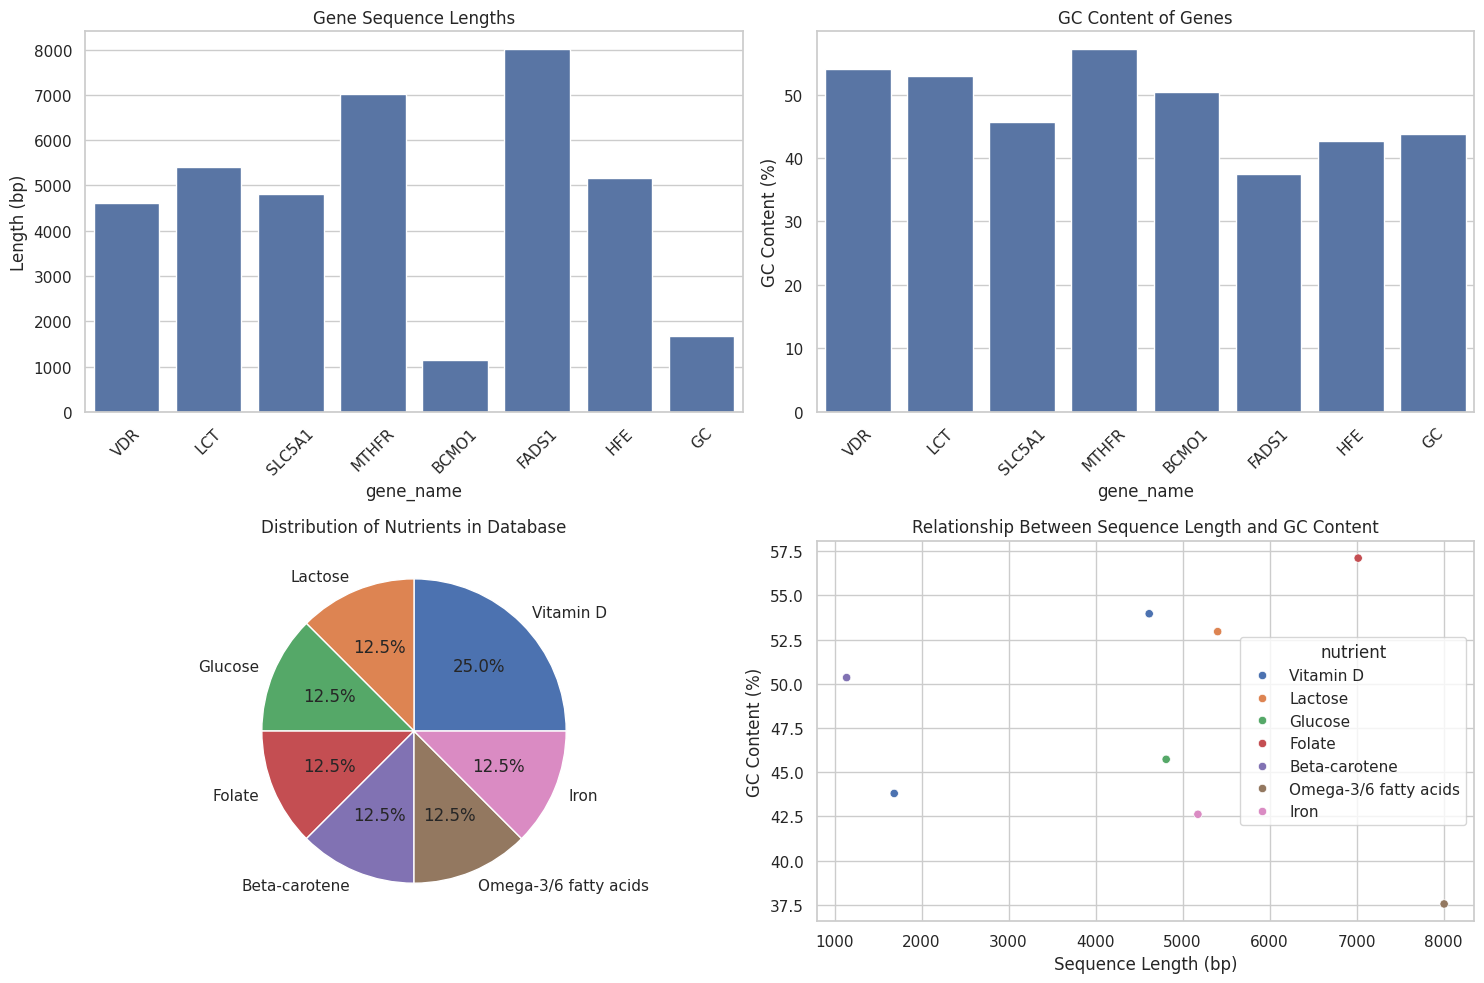

In [ ]:
# After building your gene database
gene_db = build_gene_database(nutrient_genes)

# Then call the visualization function
visualize_gene_nutrient_data(gene_db)

In [ ]:
def enhanced_visualize_gene_data(gene_db):
    """
    Create enhanced visualizations for gene-nutrient relationships for educational purposes

    Parameters:
    gene_db (pandas.DataFrame): Database of gene information

    Returns:
    None
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import pandas as pd
    from matplotlib.gridspec import GridSpec

    # Remove any rows with missing data
    clean_db = gene_db.dropna(subset=["sequence_length", "gc_content"])

    if len(clean_db) == 0:
        print("No data available for visualization")
        return

    # Set Seaborn style for better aesthetics
    sns.set(style="whitegrid")

    # Create a figure with custom layout
    fig = plt.figure(figsize=(20, 15))
    gs = GridSpec(3, 3, figure=fig)

    # 1. Bar chart of gene sequence lengths with error bars
    ax1 = fig.add_subplot(gs[0, 0:2])
    sns.barplot(x="gene_name", y="sequence_length", data=clean_db, ax=ax1)
    ax1.set_title("Gene Sequence Lengths", fontsize=14, fontweight="bold")
    ax1.set_xlabel("Gene", fontsize=12)
    ax1.set_ylabel("Length (base pairs)", fontsize=12)
    ax1.tick_params(axis='x', rotation=45)

    # 2. Heatmap of nucleotide composition
    ax2 = fig.add_subplot(gs[0, 2])
    # Extract nucleotide counts and create a composition matrix
    if "nucleotide_counts" in clean_db.columns:
        nucleotide_data = pd.DataFrame([
            row["nucleotide_counts"] for _, row in clean_db.iterrows()
        ], index=clean_db["gene_name"])

        # Normalize to get percentages
        for col in nucleotide_data.columns:
            nucleotide_data[col] = nucleotide_data[col] / nucleotide_data.sum(axis=1) * 100

        sns.heatmap(nucleotide_data, annot=True, fmt=".1f", cmap="YlGnBu", ax=ax2)
        ax2.set_title("Nucleotide Composition (%)", fontsize=14, fontweight="bold")
    else:
        ax2.text(0.5, 0.5, "Nucleotide count data not available",
                 horizontalalignment='center', verticalalignment='center')

    # 3. Grouped bar chart for gene properties by nutrient
    ax3 = fig.add_subplot(gs[1, 0:2])
    # Melt the dataframe to create grouped bars
    if len(clean_db) > 1:  # Only if we have multiple genes
        melted_db = pd.melt(clean_db,
                            id_vars=["gene_name", "nutrient"],
                            value_vars=["sequence_length", "gc_content"],
                            var_name="property", value_name="value")

        # Normalize values for better comparison
        for prop in ["sequence_length", "gc_content"]:
            max_val = melted_db[melted_db["property"] == prop]["value"].max()
            melted_db.loc[melted_db["property"] == prop, "value"] = melted_db.loc[melted_db["property"] == prop, "value"] / max_val * 100

        sns.barplot(x="gene_name", y="value", hue="property", data=melted_db, ax=ax3)
        ax3.set_title("Normalized Gene Properties by Nutrient", fontsize=14, fontweight="bold")
        ax3.set_xlabel("Gene", fontsize=12)
        ax3.set_ylabel("Normalized Value (%)", fontsize=12)
        ax3.tick_params(axis='x', rotation=45)
        ax3.legend(title="Property")

        # Add nutrient information as text above each bar
        for i, gene in enumerate(clean_db["gene_name"]):
            nutrient = clean_db[clean_db["gene_name"] == gene]["nutrient"].values[0]
            ax3.text(i, 105, nutrient, ha='center', rotation=45, fontsize=10, fontweight='bold')
    else:
        ax3.text(0.5, 0.5, "Insufficient data for grouped comparison",
                 horizontalalignment='center', verticalalignment='center')

    # 4. Bubble chart of sequence length, GC content, and nutrient
    ax4 = fig.add_subplot(gs[1, 2])
    if len(clean_db) > 1:  # Only if we have multiple genes
        # Create a color map for nutrients
        nutrients = clean_db["nutrient"].unique()
        color_map = dict(zip(nutrients, sns.color_palette("Set2", len(nutrients))))
        colors = [color_map[nutrient] for nutrient in clean_db["nutrient"]]

        # Create bubble sizes based on sequence length
        sizes = clean_db["sequence_length"] / clean_db["sequence_length"].max() * 500

        scatter = ax4.scatter(clean_db["gene_name"], clean_db["gc_content"],
                  s=sizes, c=colors, alpha=0.7)

        # Add legend for nutrients
        handles = [plt.Line2D([0], [0], marker='o', color='w',
                              markerfacecolor=color_map[nutrient], markersize=10, label=nutrient)
                  for nutrient in nutrients]
        ax4.legend(handles=handles, title="Nutrient", loc="upper right")

        ax4.set_title("GC Content with Sequence Length as Bubble Size", fontsize=14, fontweight="bold")
        ax4.set_xlabel("Gene", fontsize=12)
        ax4.set_ylabel("GC Content (%)", fontsize=12)
        ax4.tick_params(axis='x', rotation=45)
    else:
        ax4.text(0.5, 0.5, "Insufficient data for bubble chart",
                 horizontalalignment='center', verticalalignment='center')

    # 5. Gene function visualization (simplified)
    ax5 = fig.add_subplot(gs[2, 0:3])
    if "function" in clean_db.columns:
        # Create a table to display gene functions
        cell_text = []
        for _, row in clean_db.iterrows():
            cell_text.append([row["gene_name"], row["nutrient"], row["function"]])

        column_labels = ["Gene", "Nutrient", "Function"]
        table = ax5.table(cellText=cell_text, colLabels=column_labels,
                         loc='center', cellLoc='center')

        # Style the table
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 1.5)

        ax5.set_title("Gene Functions and Associated Nutrients", fontsize=14, fontweight="bold")
        ax5.axis('off')
    else:
        ax5.text(0.5, 0.5, "Function data not available",
                 horizontalalignment='center', verticalalignment='center')

    plt.tight_layout()
    plt.savefig('gene_nutrient_visualizations.png', dpi=300)
    plt.show()

    # Optional: Create a separate figure for pathway visualization
    plt.figure(figsize=(12, 8))

    # Create a simplified metabolic pathway visualization
    pathway_fig = plt.figure(figsize=(15, 10))
    ax = pathway_fig.add_subplot(1, 1, 1)

    # Create node positions for genes and nutrients
    genes = clean_db["gene_name"].tolist()
    nutrients = clean_db["nutrient"].unique().tolist()

    gene_positions = {}
    nutrient_positions = {}

    # Calculate positions in a circular layout
    gene_radius = 0.6
    nutrient_radius = 0.3

    # Position genes in outer circle
    for i, gene in enumerate(genes):
        angle = 2 * np.pi * i / len(genes)
        x = gene_radius * np.cos(angle)
        y = gene_radius * np.sin(angle)
        gene_positions[gene] = (x, y)

    # Position nutrients in inner circle
    for i, nutrient in enumerate(nutrients):
        angle = 2 * np.pi * i / len(nutrients)
        x = nutrient_radius * np.cos(angle)
        y = nutrient_radius * np.sin(angle)
        nutrient_positions[nutrient] = (x, y)

    # Draw nodes and connections
    # Genes as rectangles
    for gene, (x, y) in gene_positions.items():
        rect = plt.Rectangle((x-0.05, y-0.03), 0.1, 0.06, facecolor='skyblue',
                           edgecolor='black', alpha=0.8)
        ax.add_patch(rect)
        ax.text(x, y, gene, ha='center', va='center', fontsize=10, fontweight='bold')

    # Nutrients as circles
    for nutrient, (x, y) in nutrient_positions.items():
        circle = plt.Circle((x, y), 0.05, facecolor='lightgreen',
                           edgecolor='black', alpha=0.8)
        ax.add_patch(circle)
        ax.text(x, y, nutrient, ha='center', va='center', fontsize=9)

    # Draw connections between genes and their associated nutrients
    for _, row in clean_db.iterrows():
        gene = row["gene_name"]
        nutrient = row["nutrient"]
        if gene in gene_positions and nutrient in nutrient_positions:
            gene_x, gene_y = gene_positions[gene]
            nutrient_x, nutrient_y = nutrient_positions[nutrient]
            ax.plot([gene_x, nutrient_x], [gene_y, nutrient_y], 'k-', alpha=0.5)

    ax.set_xlim(-0.8, 0.8)
    ax.set_ylim(-0.8, 0.8)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title("Gene-Nutrient Relationship Network", fontsize=16, fontweight="bold")

    plt.tight_layout()
    plt.savefig('gene_nutrient_network.png', dpi=300)
    plt.show()

# Additional function for sequence pattern visualization
def visualize_sequence_patterns(gene_db):
    """
    Visualize sequence patterns and motifs in genes

    Parameters:
    gene_db (pandas.DataFrame): Database of gene information

    Returns:
    None
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    from collections import Counter

    # Check if we have sequence data
    if "sequence" not in gene_db.columns or gene_db["sequence"].isna().all():
        print("No sequence data available for pattern visualization")
        return

    # Remove rows with missing sequence data
    seq_db = gene_db.dropna(subset=["sequence"])

    if len(seq_db) == 0:
        print("No sequence data available after filtering")
        return

    plt.figure(figsize=(16, 12))

    # 1. Dinucleotide frequency analysis
    plt.subplot(2, 2, 1)

    # Collect dinucleotide frequencies
    dinucleotide_data = {}
    for _, row in seq_db.iterrows():
        seq = row["sequence"]
        gene = row["gene_name"]

        if not seq or len(seq) < 2:
            continue

        # Count dinucleotides
        dinucleotides = [seq[i:i+2] for i in range(len(seq)-1)]
        dinuc_counts = Counter(dinucleotides)

        # Calculate frequencies (normalized)
        total = sum(dinuc_counts.values())
        dinuc_freq = {k: v/total for k, v in dinuc_counts.items()}

        # Store top dinucleotides
        top_dinucs = sorted(dinuc_freq.items(), key=lambda x: x[1], reverse=True)[:10]
        dinucleotide_data[gene] = {k: v for k, v in top_dinucs}

    # Plot dinucleotide frequencies
    if dinucleotide_data:
        # Find common dinucleotides across genes
        all_dinucs = set()
        for gene_data in dinucleotide_data.values():
            all_dinucs.update(gene_data.keys())

        # Prepare data for plotting
        plot_data = []
        common_dinucs = list(all_dinucs)[:8]  # Limit to 8 most common

        for gene, gene_data in dinucleotide_data.items():
            for dinuc in common_dinucs:
                plot_data.append({
                    'Gene': gene,
                    'Dinucleotide': dinuc,
                    'Frequency': gene_data.get(dinuc, 0)
                })

        # Convert to DataFrame for seaborn
        import pandas as pd
        dinuc_df = pd.DataFrame(plot_data)

        # Create heatmap
        pivot_df = dinuc_df.pivot(index='Gene', columns='Dinucleotide', values='Frequency')
        sns.heatmap(pivot_df, annot=True, fmt=".3f", cmap="YlGnBu")
        plt.title("Dinucleotide Frequencies in Genes", fontsize=14)
        plt.ylabel("Gene")
        plt.xlabel("Dinucleotide")
    else:
        plt.text(0.5, 0.5, "Insufficient data for dinucleotide analysis",
                 horizontalalignment='center', verticalalignment='center')

    # 2. Base distribution along sequence
    plt.subplot(2, 2, 2)

    # Select a sample gene to visualize (the first one with sequence)
    sample_gene = None
    for _, row in seq_db.iterrows():
        if row["sequence"] and len(row["sequence"]) > 100:
            sample_gene = row
            break

    if sample_gene is not None:
        seq = sample_gene["sequence"]

        # Take first 1000 bases or the full sequence if shorter
        seq_len = min(1000, len(seq))
        seq = seq[:seq_len]

        # Count bases along the sequence in windows
        window_size = 50
        positions = list(range(0, seq_len, window_size))

        a_counts = []
        t_counts = []
        g_counts = []
        c_counts = []

        for i in positions:
            window = seq[i:i+window_size]
            total = len(window)

            a_counts.append(window.count('A') / total * 100)
            t_counts.append(window.count('T') / total * 100)
            g_counts.append(window.count('G') / total * 100)
            c_counts.append(window.count('C') / total * 100)

        # Plot distribution
        plt.plot(positions, a_counts, 'r-', label='A')
        plt.plot(positions, t_counts, 'g-', label='T')
        plt.plot(positions, g_counts, 'b-', label='G')
        plt.plot(positions, c_counts, 'y-', label='C')

        plt.title(f"Base Distribution Along {sample_gene['gene_name']} Sequence", fontsize=14)
        plt.xlabel("Position in Sequence (bp)")
        plt.ylabel("Base Percentage (%)")
        plt.legend()
    else:
        plt.text(0.5, 0.5, "No suitable sequence data for base distribution analysis",
                 horizontalalignment='center', verticalalignment='center')

    # 3. Sequence complexity visualization
    plt.subplot(2, 2, 3)

    # Calculate sequence complexity for each gene
    complexity_data = []

    for _, row in seq_db.iterrows():
        if not row["sequence"] or len(row["sequence"]) < 100:
            continue

        seq = row["sequence"]
        gene = row["gene_name"]

        # Calculate complexity using rolling window entropy
        window_size = 50
        overlap = 25

        entropies = []
        for i in range(0, len(seq) - window_size + 1, overlap):
            window = seq[i:i+window_size]

            # Calculate Shannon entropy
            counts = Counter(window)
            total = sum(counts.values())
            entropy = -sum((count/total) * np.log2(count/total) for count in counts.values())
            entropies.append(entropy)

        # Positions for plotting
        positions = list(range(0, len(seq) - window_size + 1, overlap))

        # Add to plot
        plt.plot(positions, entropies, label=gene)

    if complexity_data or len(plt.gca().get_lines()) > 0:
        plt.title("Sequence Complexity (Shannon Entropy)", fontsize=14)
        plt.xlabel("Position in Sequence (bp)")
        plt.ylabel("Entropy")
        plt.legend()
    else:
        plt.text(0.5, 0.5, "Insufficient data for complexity analysis",
                 horizontalalignment='center', verticalalignment='center')

    # 4. Common motifs visualization
    plt.subplot(2, 2, 4)

    # Look for common DNA motifs (simplified)
    common_motifs = [
        "TATA",  # TATA box
        "CAAT",  # CAAT box
        "GATA",  # GATA binding site
        "GGAA",  # ETS binding site
        "CCAAT", # CCAAT box
        "GGGCGG", # SP1 binding site
        "AATAAA"  # Polyadenylation signal
    ]

    motif_data = []

    for _, row in seq_db.iterrows():
        if not row["sequence"]:
            continue

        seq = row["sequence"]
        gene = row["gene_name"]

        # Count motifs
        for motif in common_motifs:
            count = seq.count(motif)

            # Normalize by sequence length
            freq = count / len(seq) * 1000  # Per 1000 bp

            motif_data.append({
                'Gene': gene,
                'Motif': motif,
                'Frequency': freq
            })

    if motif_data:
        # Convert to DataFrame
        import pandas as pd
        motif_df = pd.DataFrame(motif_data)

        # Plot heatmap
        pivot_df = motif_df.pivot(index='Gene', columns='Motif', values='Frequency')
        sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap="YlOrRd")
        plt.title("Common DNA Motifs (Per 1000 bp)", fontsize=14)
        plt.ylabel("Gene")
        plt.xlabel("Motif")
    else:
        plt.text(0.5, 0.5, "Insufficient data for motif analysis",
                 horizontalalignment='center', verticalalignment='center')

    plt.tight_layout()
    plt.savefig('sequence_patterns.png', dpi=300)
    plt.show()

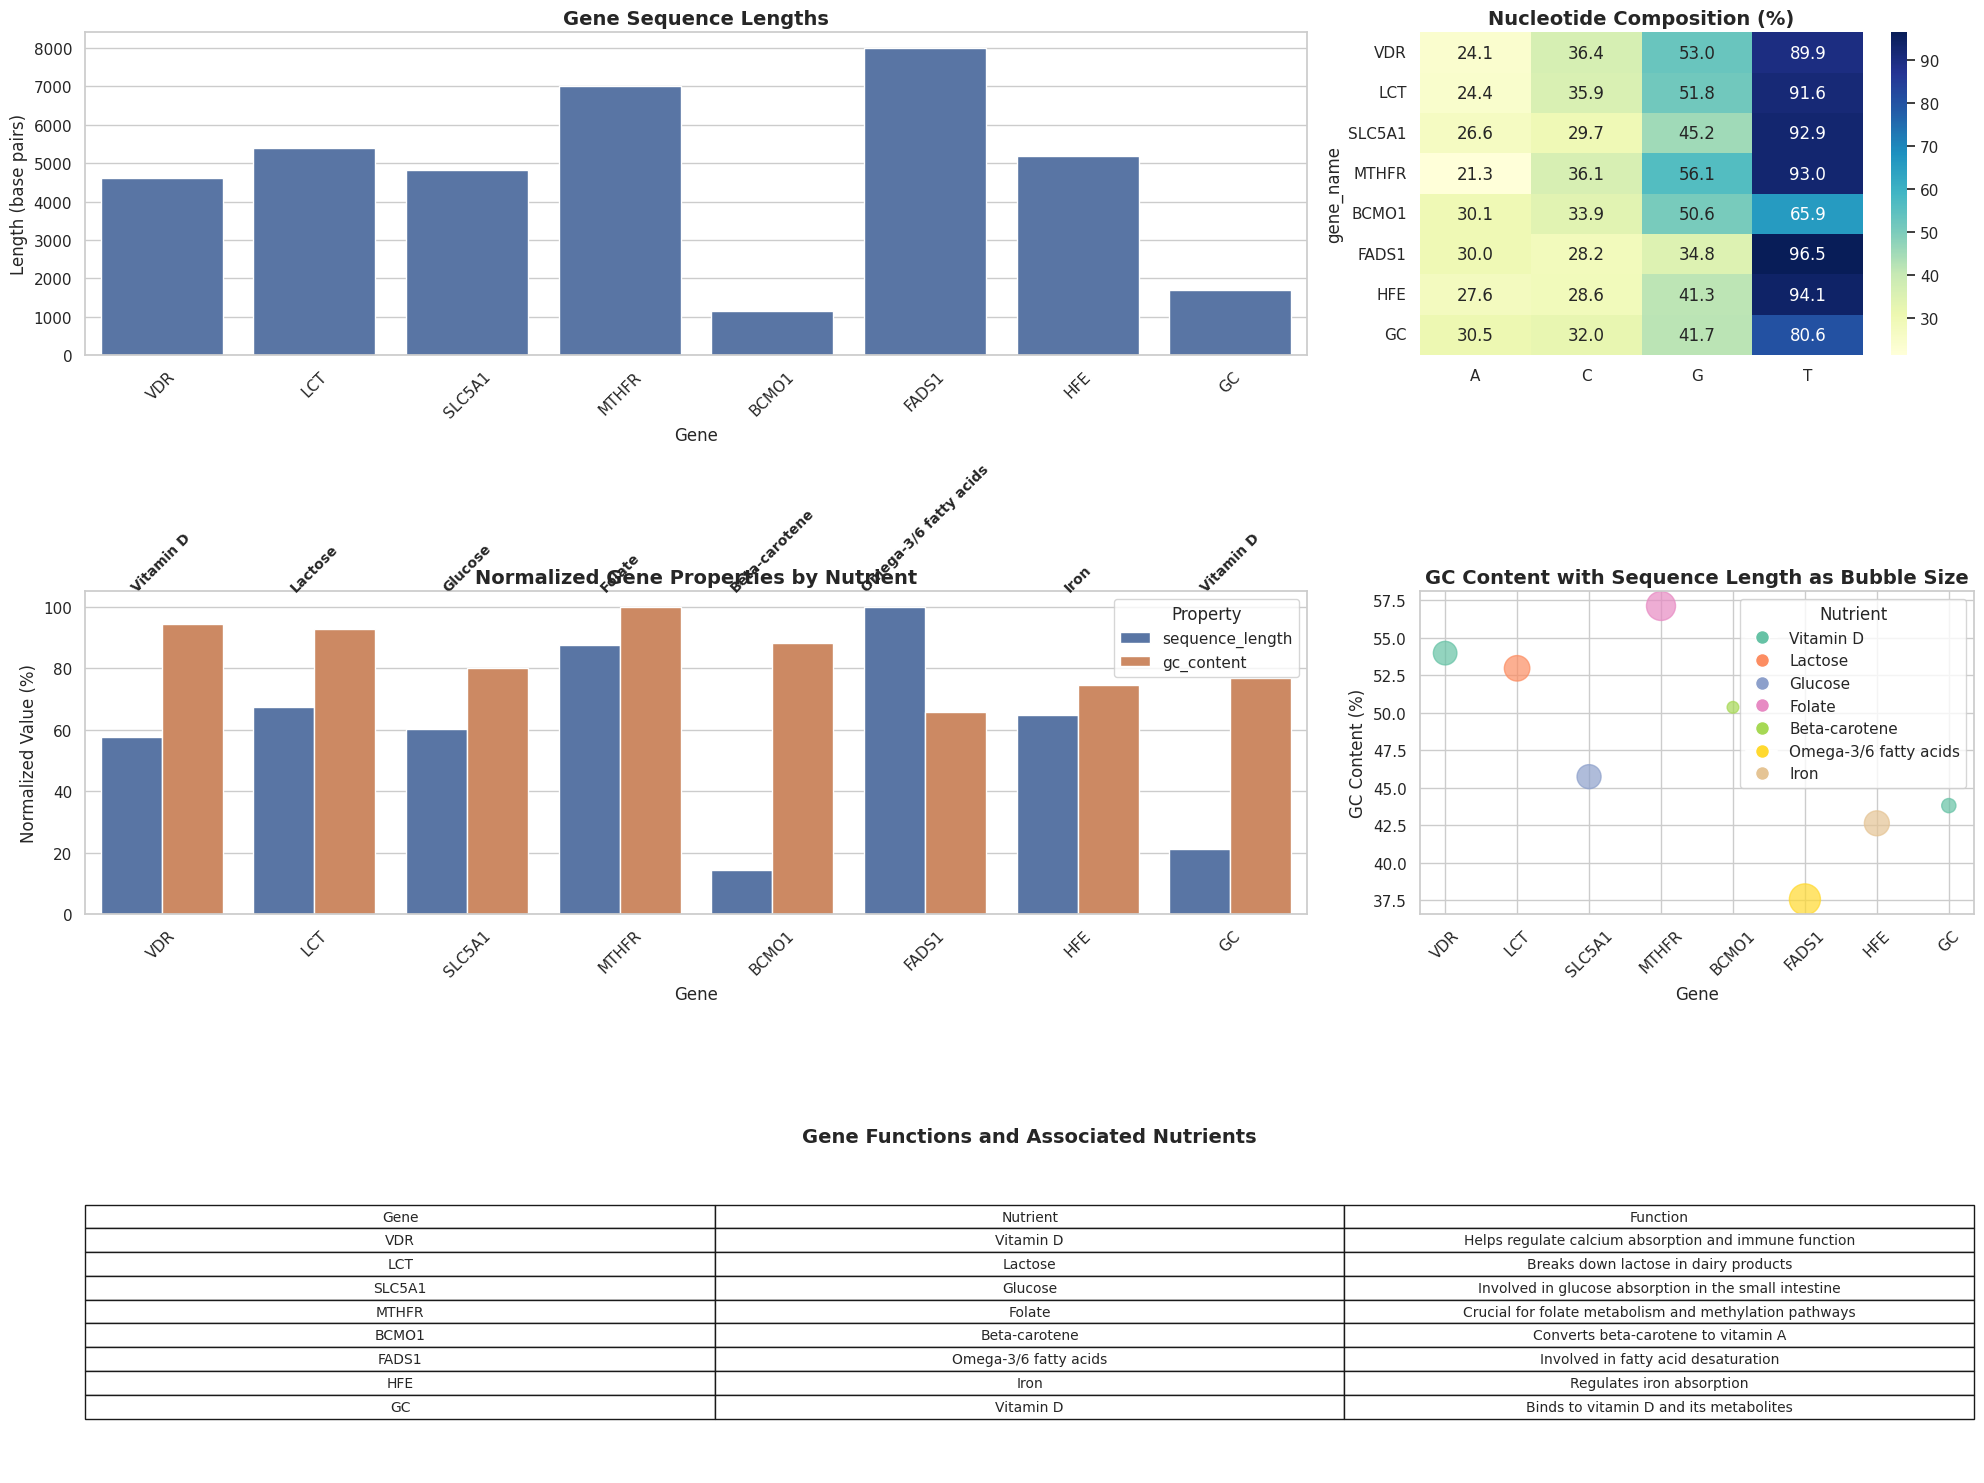

<Figure size 1200x800 with 0 Axes>

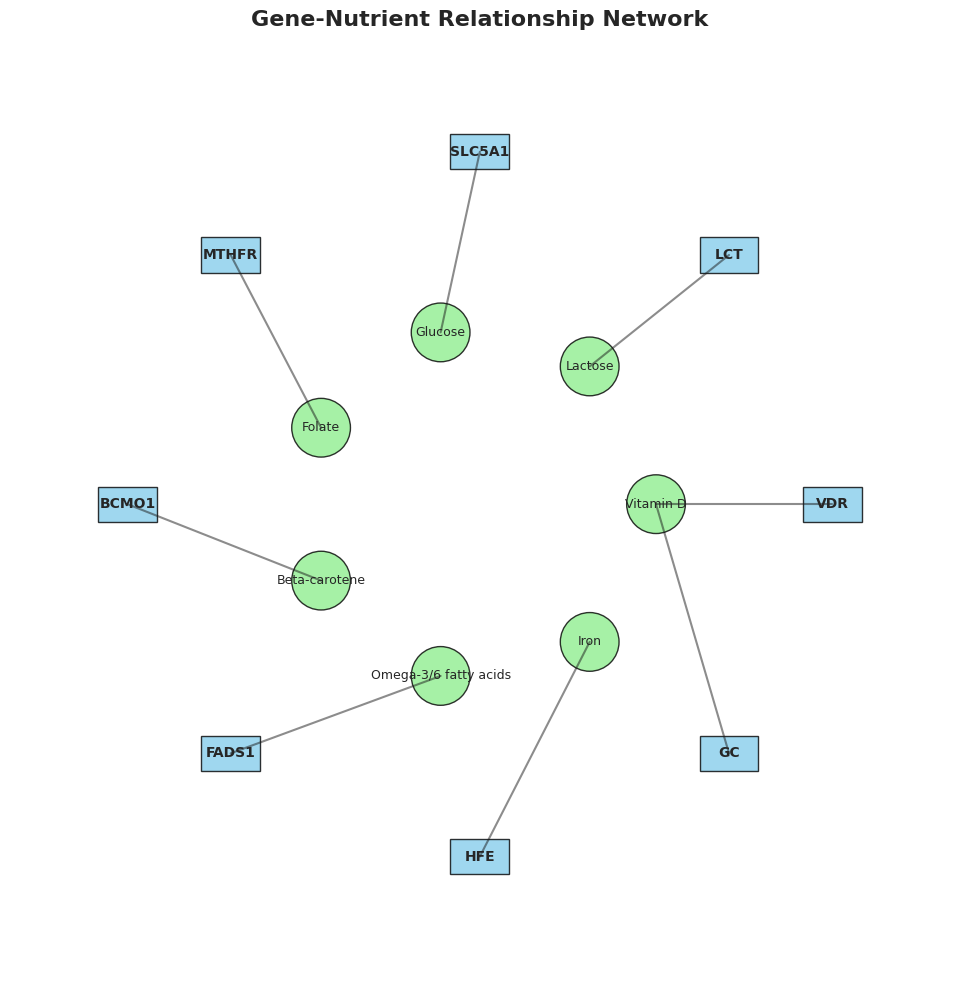

In [ ]:
enhanced_visualize_gene_data(gene_db)


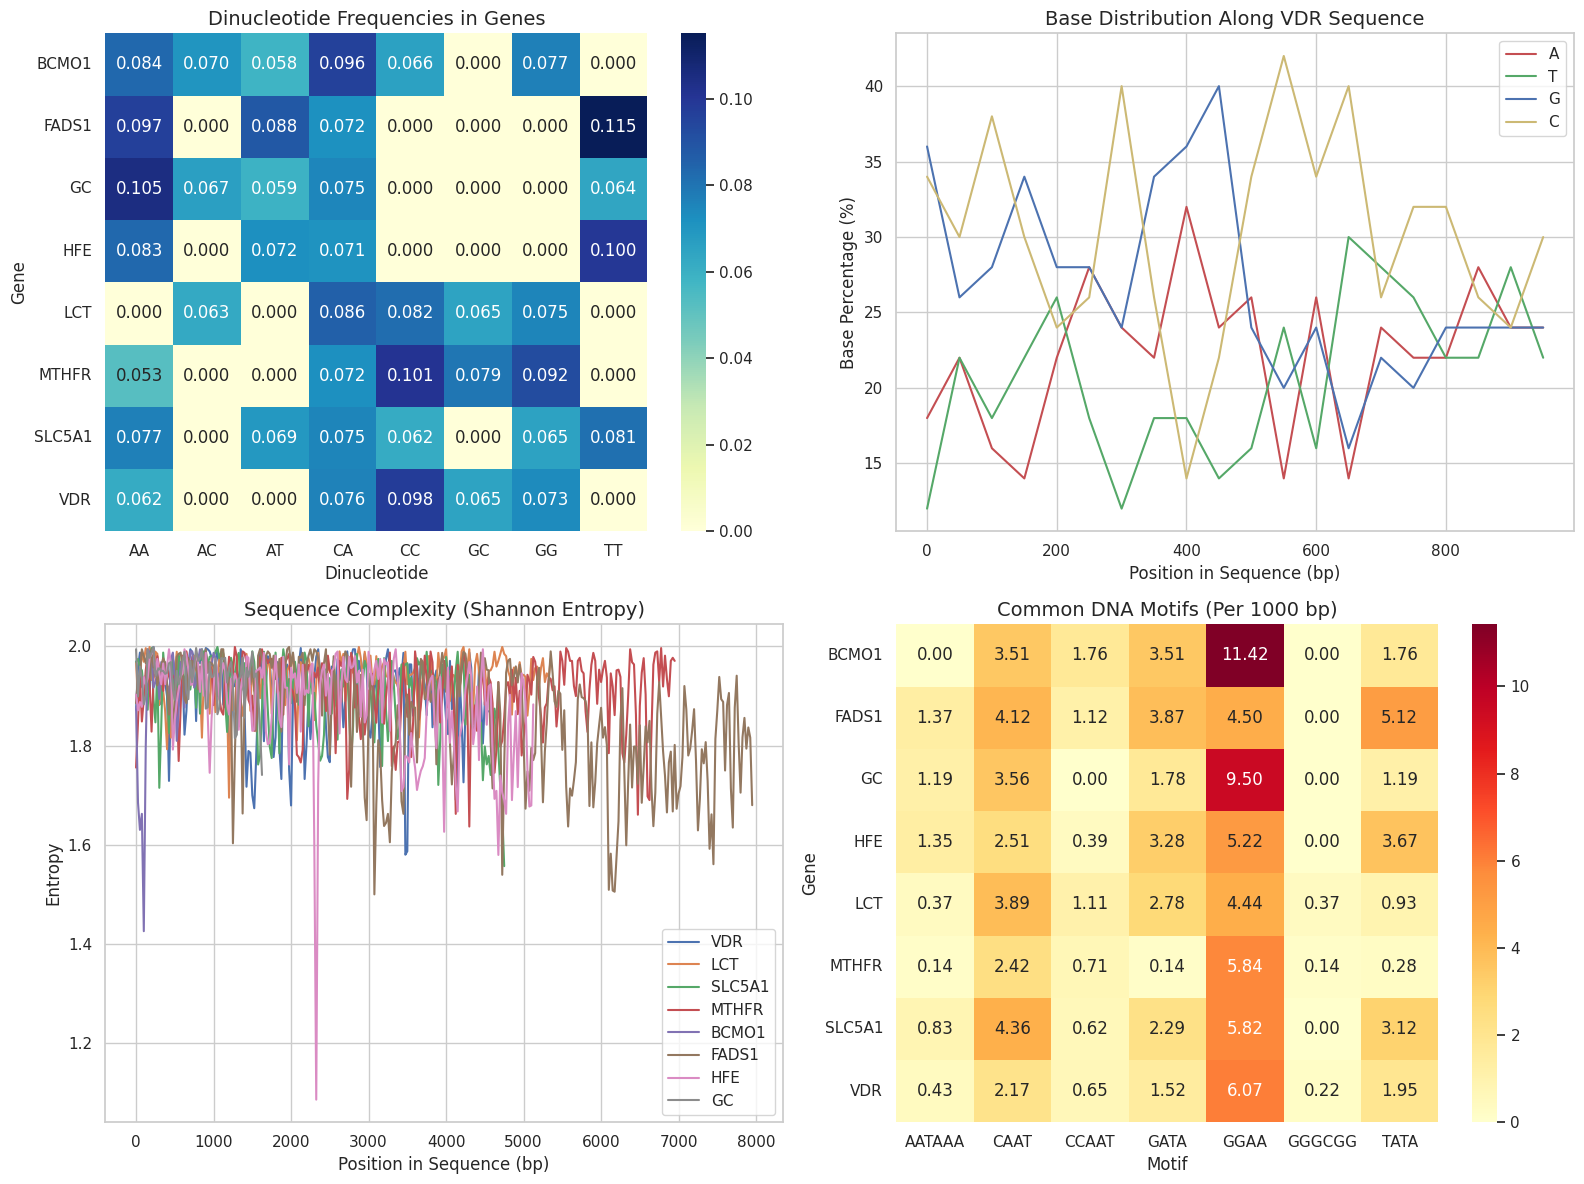

In [ ]:
visualize_sequence_patterns(gene_db)